# Converting a floor plan image to wall lines and openings

In [1]:
import cv2
import matplotlib.pyplot as plt

IMG_1_PATH = "./img/example_1.png"
IMG_2_PATH = "./img/example_2.jpg"

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Let's take two example floor plan images.

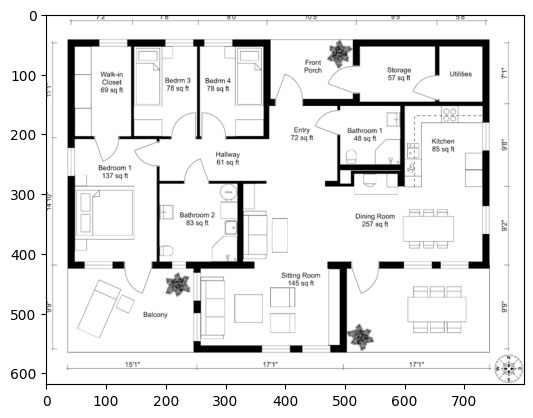

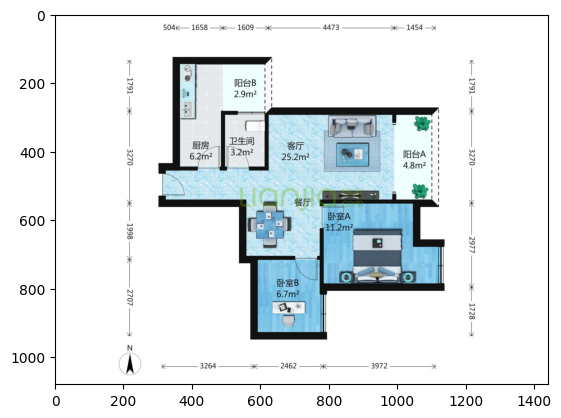

In [2]:
def display_img(path: str):
    img = cv2.imread(path)
    plt.imshow(img)
    plt.show()
    return img

img_1 = display_img(IMG_1_PATH)
img_2 = display_img(IMG_2_PATH)


## Remove text

Remove text artifacts from the picture. Detect text with OCR using a neural network, then inpaint the text position. 

As a general guideline, this is the sign that a trained neural network model and inpainting techniques can be used to standardize the floor plan images. 

In [3]:
import keras_ocr
import numpy as np
import math

2023-06-27 08:29:59.490950: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2) / 2)
    y_mid = int((y1 + y2) / 2)
    return (x_mid, y_mid)

def inpaint_text(img_path: str, pipeline: keras_ocr.pipeline.Pipeline):
    # read image
    img = keras_ocr.tools.read(img_path)
    # generate (word, box) tuples
    prediction_groups = pipeline.recognize([img])

    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1]
        x2, y2 = box[1][2]
        x3, y3 = box[1][3]

        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)

        thickness = int(math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2))

        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255, thickness)
        # CV2 inpainting
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)

    return img

ocr_pipeline = keras_ocr.pipeline.Pipeline()

Looking for /Users/Nicolas_Oulianov/.keras-ocr/craft_mlt_25k.h5


2023-06-27 08:30:23.317458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 08:30:23.318273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-27 08:30:23.319245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Looking for /Users/Nicolas_Oulianov/.keras-ocr/crnn_kurapan.h5


In [5]:
img_1_without_text = inpaint_text(IMG_1_PATH, ocr_pipeline)
img_2_without_text = inpaint_text(IMG_2_PATH, ocr_pipeline)

1/1 [==============================] - 7s 7s/step


2023-06-27 08:30:31.257226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 08:30:31.258108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-27 08:30:31.258943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 2s 238ms/step


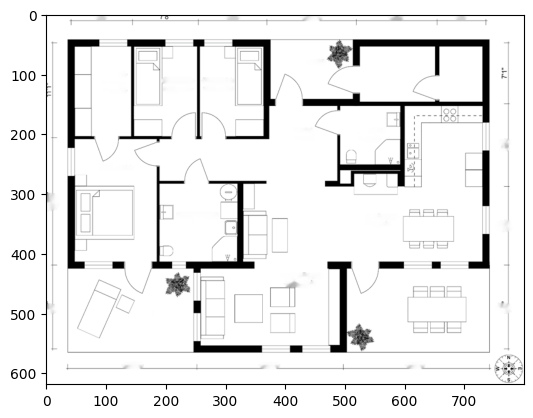

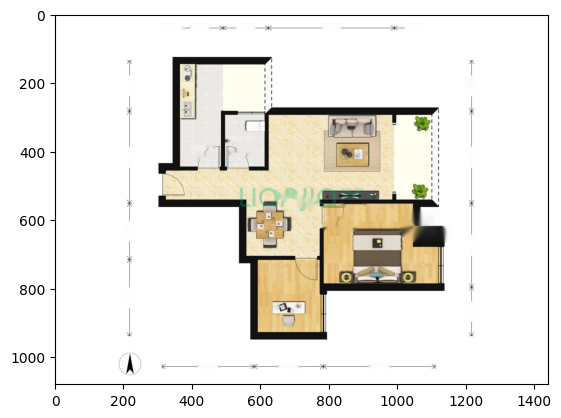

In [6]:
plt.imshow(img_1_without_text)
plt.show()

plt.imshow(img_2_without_text)
plt.show()

## Preprocess for edge detection

We're gonna use an edge detection algorithm to capture the geometry behind the thick, black lines that represent the walls. 

We want an image in black and white with mostly those walls. 

In [7]:
def preprocess_image(img):
    # Grayscale and 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Remove details and noise with blur
    kernel_size = 5
    blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    # Black and white to keep mostly the black
    _, thresh = cv2.threshold(blur, 30, 255, cv2.THRESH_BINARY)
    
    # Make the black walls white (more idiomatic in contour detection)
    thresh = 255 - thresh

    # inflate to group small clusters of pixels
    thresh = cv2.dilate(thresh, np.ones((8, 8), np.uint8), iterations=2)
    
    # Erode to remove small lines
    thresh = cv2.erode(thresh, np.ones((8, 8), np.uint8), iterations=1)

    return thresh

preprocessed_img_1 = preprocess_image(img_1_without_text)
preprocessed_img_2 = preprocess_image(img_2_without_text)

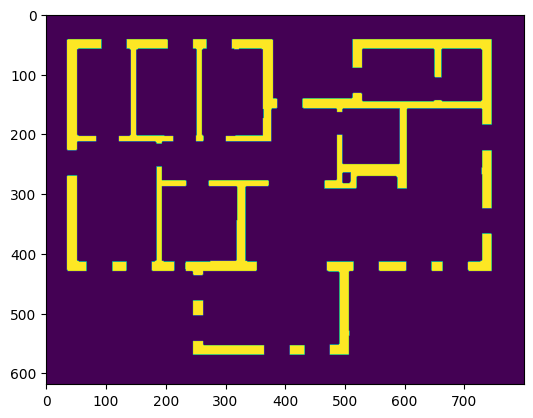

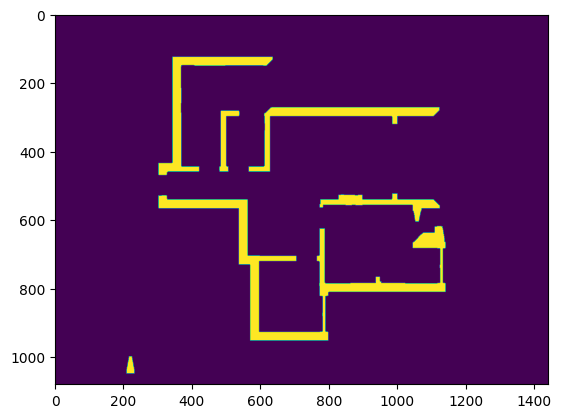

In [8]:
plt.imshow(preprocessed_img_1)
plt.show()

plt.imshow(preprocessed_img_2)
plt.show()

Preprocessing is not perfect.
- Removes windows
- Only works with thick black walls
- interprets some dark objects as walls

How to improve :
- Better detect zone of interest to be cropped (ex: to remove exterior lines and symbols)
- Better preprocessing with neural network to remove objects 
- Downstream improvements to find rectangles and fill the missing walls 
- UX improvement to make those issues easy to deal with

## Detect geometry

Our taks of detecting walls and doors is similar to edge or contour detection.

We also want to transform the plan into a vectorized format. 

In [9]:
def draw_contours(contour, background_img):
    drawn_img = background_img.copy()
    cv2.drawContours(drawn_img, [contour], 0, (255, 0, 255), 5)
    return drawn_img

## Detect individual shapes

Each separate thick black wall becomes a single shape. 

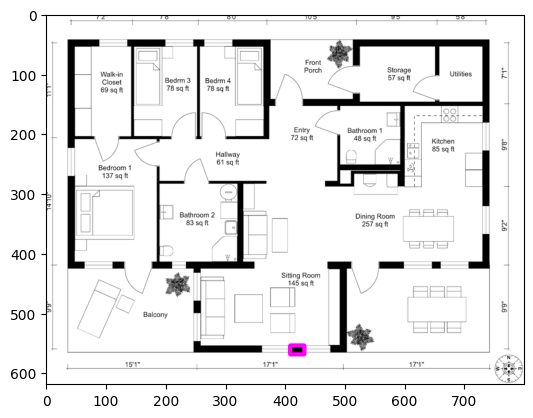

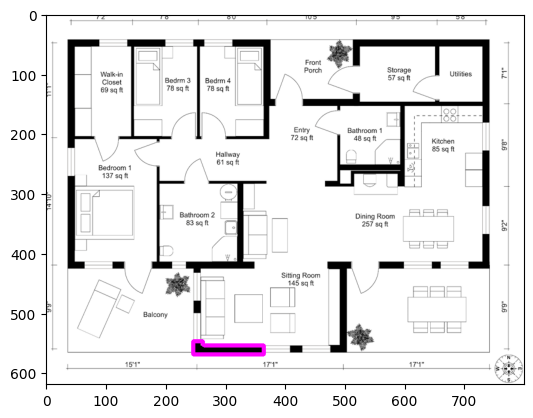

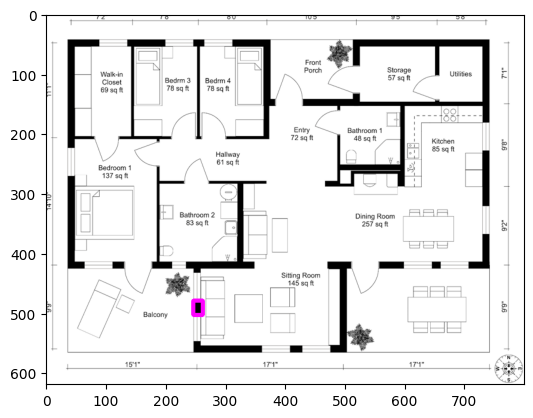

In [10]:
contours_1, _ = cv2.findContours(preprocessed_img_1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_2, _ = cv2.findContours(preprocessed_img_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Example for 3 detected pieces
for c in contours_1[:3]: 
    drawn_img = draw_contours(c, img_1)
    plt.imshow(drawn_img)
    plt.show()

## Find doorways

In [24]:
from typing import List, Optional
from dataclasses import dataclass
from collections import defaultdict

@dataclass
class Segment:
    start: List[int]
    end: List[int]
    contour_id: Optional[int]
    
    @property
    def midpoint(self):
        return midpoint(self.start[0], self.start[1], self.end[0], self.end[1])

    @property
    def angle(self):
        angle = math.atan2(self.end[0] - self.start[0], self.end[1] - self.start[1])
        return angle % math.pi / 2

    @property
    def len(self):
        return math.sqrt((self.end[1] - self.start[1])**2 + (self.end[0] - self.start[0])**2)

    def __key(self):
        key = f'{self.angle}'

        mid_x, mid_y = midpoint(self.start[0], self.start[1], self.end[0], self.end[1])
        mid_x = int(mid_x/20)
        mid_y = int(mid_x/20)

        if self.angle < math.pi/8:
            key += f"{mid_y}"
        if self.angle > 7/8*math.pi/2:
            key += f"{mid_x}"

        return key

    def __hash__(self) -> int:
        return hash(self.__key())

    def __eq__(self, other):
        if isinstance(other, Segment):
            return self.__key() == other.__key()

    def to_numpy(self):
        return np.array([self.start[0], self.start[1], self.end[0], self.end[1]])

In [25]:
# Transform contours into a collection of segments
segments = []
for c_id, c in enumerate(contours_1):
    previous_point = c[-1]
    for point in c:
        segment = Segment(start=previous_point[0], end=point[0], contour_id=c_id)
        segments.append(segment)
        previous_point = point

In [26]:
def segments_distance(seg1: Segment, seg2: Segment):
    return math.sqrt((seg2.midpoint[0] - seg1.midpoint[0])**2 + (seg2.midpoint[1] - seg1.midpoint[1])**2)

In [61]:
# Find small, near, parallel lines

WALL_MIN_WIDTH = 5
WALL_MAX_WIDTH = 20
DOOR_MIN_SIZE = 30
DOOR_MAX_SIZE = 50

candidate_doorways = []
for s_ref in segments:
    if (WALL_MIN_WIDTH < s_ref.len < WALL_MAX_WIDTH): # Only consider small segments
        # Find all parallel and small segments
        parallel_segments = [s for s in segments 
                if abs(s.angle - s_ref.angle) < 0.001 # parallel
                and (WALL_MIN_WIDTH < s.len < WALL_MAX_WIDTH) # small 
                and (DOOR_MIN_SIZE < segments_distance(s_ref, s) < DOOR_MAX_SIZE) ]
        if parallel_segments:
            # Pick the closest one 
            parallel_segments = sorted(parallel_segments, key=lambda x: x.len)
            s_candidate = parallel_segments[0]
            candidate_doorways.append([s_ref, s_candidate])

# TODO : Deduplicate doorways
        

TypeError: unhashable type: 'list'

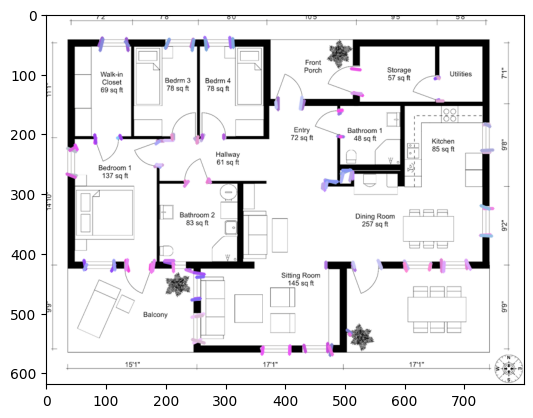

In [62]:
from random import randint

def draw_segments(segments: List[Segment], background_img):
    img = background_img.copy()
    seg_color = (randint(127, 255), randint(64, 200), randint(200, 255))
    if segments:
        for segment in segments:
            # if len(l.shape) > 0:
            #     l = l[0]
            jitter = 8
            cv2.line(img, (segment.start[0] + randint(0, jitter) - int(jitter/2), 
                segment.start[1] + randint(0, jitter) - int(jitter/2)), 
                (segment.end[0] + randint(0, jitter) - int(jitter/2), 
                segment.end[1] + randint(0, jitter) - int(jitter/2)), 
                seg_color, 3, cv2.LINE_AA)
    return img

ex = None
for dw in candidate_doorways:
    if ex is None:
        ex = draw_segments(dw, img_1)
    else:
        ex = draw_segments(dw, ex)

plt.imshow(ex)
plt.show()


## Simplify the shapes into lines that make them up

We group segments that have similar angle.

Todo : Simplify each shape into minimal partition of rectangles

Then, do the deduplication on the rectangle level : deduplicate based on angle and keep only the largest segment. 

https://github.com/mittalgovind/Polygon-Partition

Note : this will work for blocky shapes. Need to handle round shapes as well. 

In [242]:
def draw_lines(lines, background_img):
    img = background_img.copy()
    if lines is not None:
        for i in range(0, len(lines)):
            l = lines[i]
            # if len(l.shape) > 0:
            #     l = l[0]
            cv2.line(img, (l[0], l[1]), (l[2], l[3]), (255, 0, 255), 3, cv2.LINE_AA)
    return img

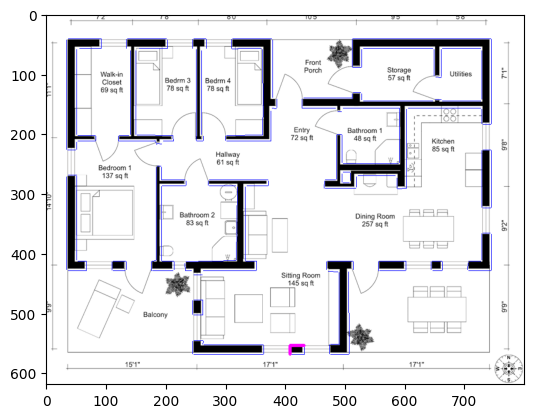

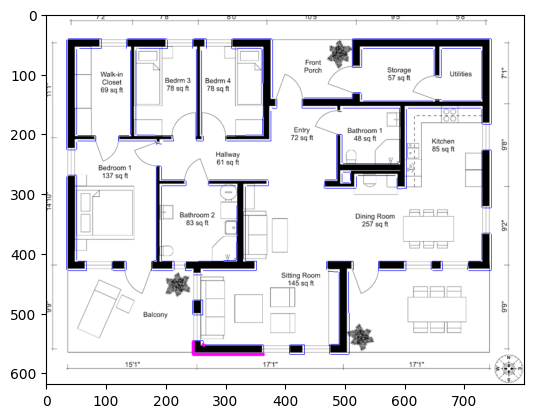

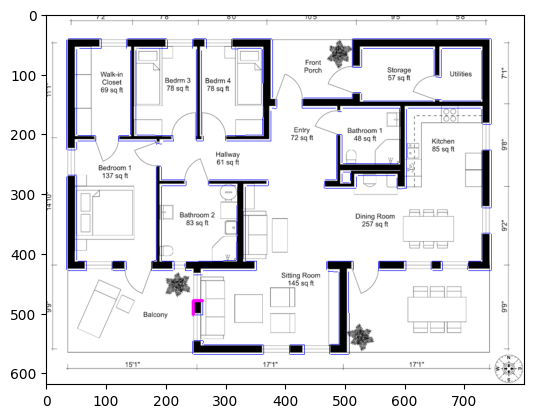

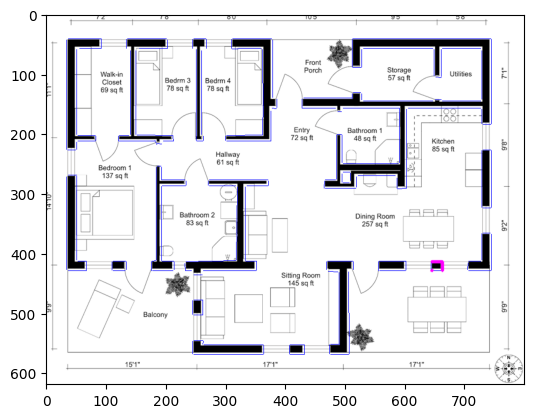

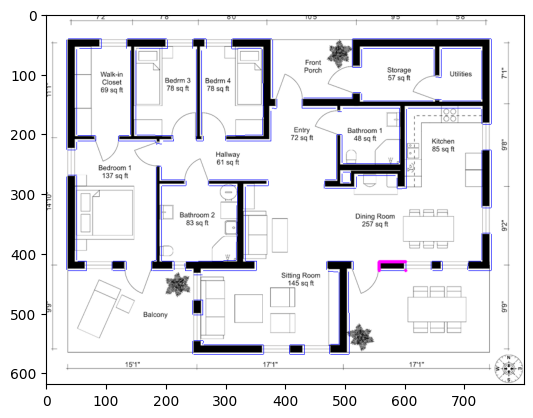

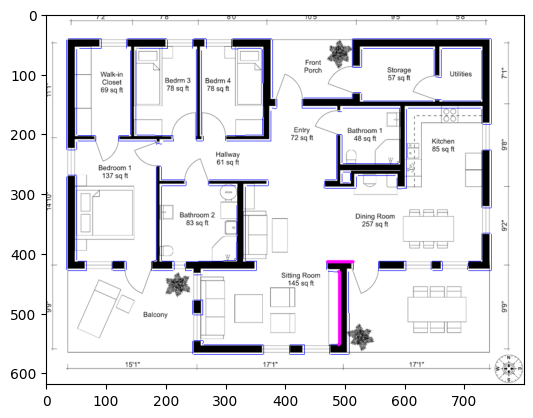

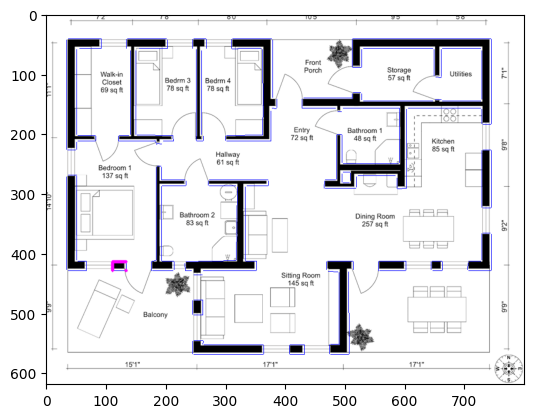

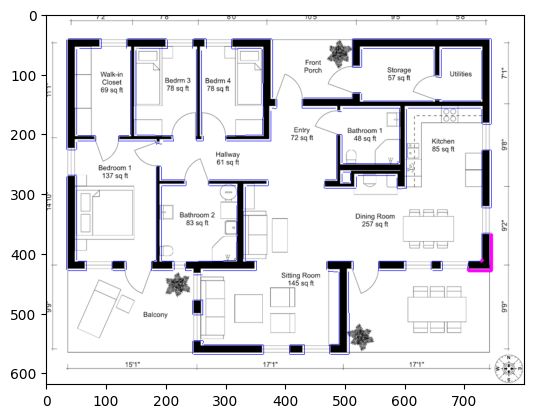

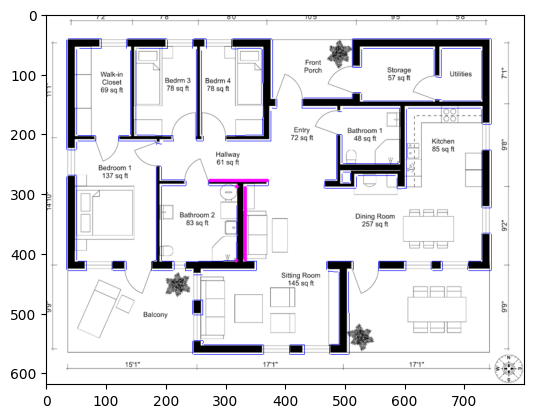

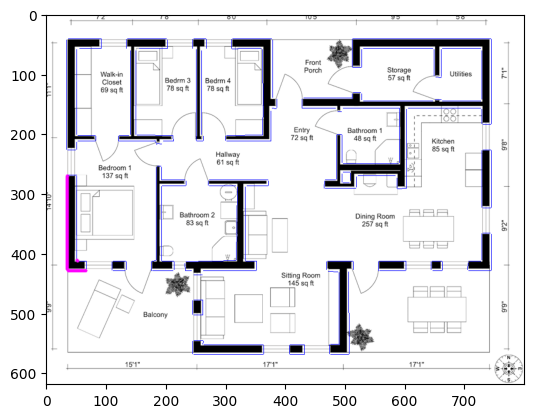

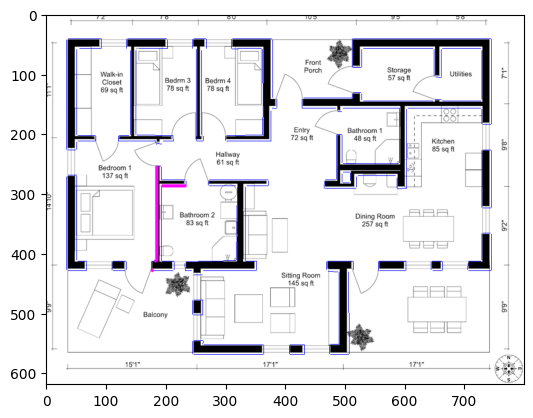

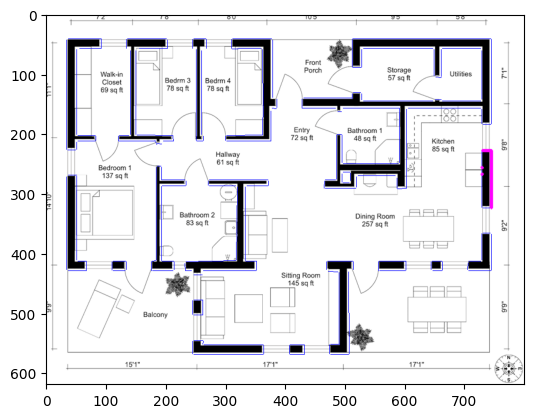

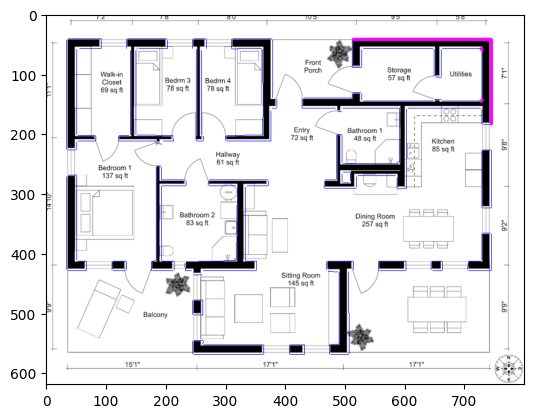

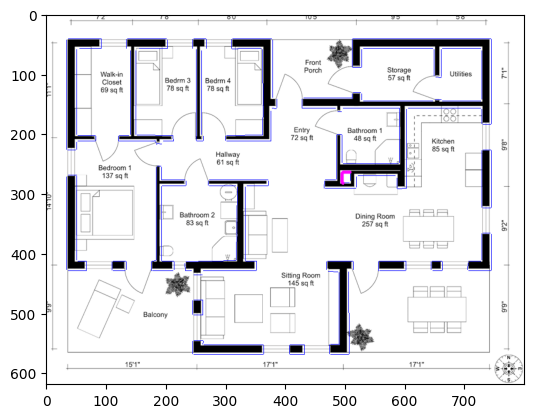

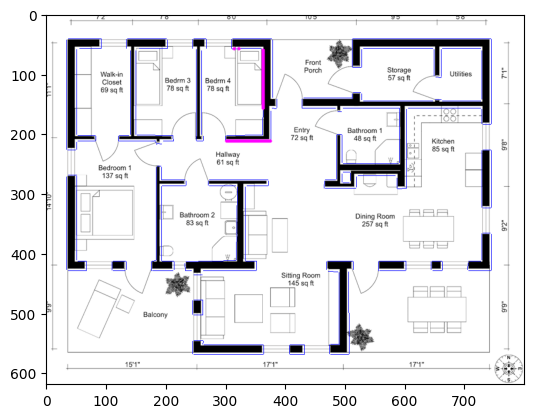

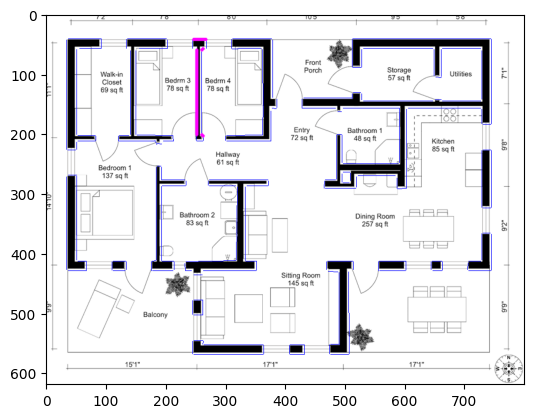

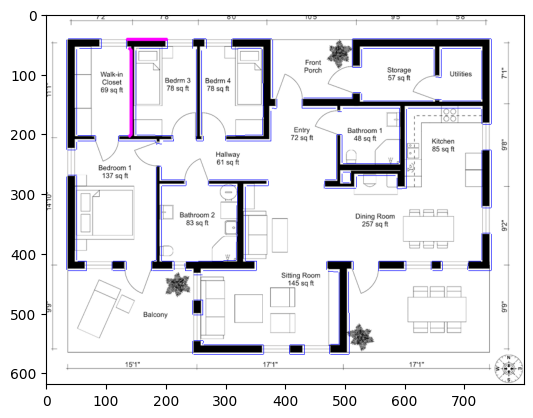

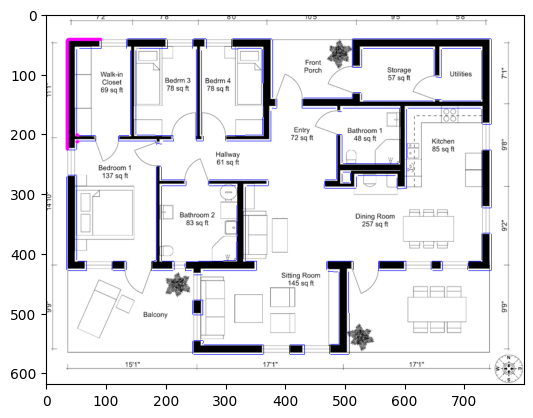

In [273]:
def simplify_contour(c: np.ndarray):
    segments = []
    previous_point = c[-1]
    for point in c:
        segment = Segment(start=previous_point[0], end=point[0])
        segments.append(segment)
        previous_point = point

    # Keep longest segments
    segments = sorted(segments, key=lambda s: -s.len)
    # TODO : To a better segment deduplication algorithm 
    # Split into sub rectangles 

    unique_segments = set(segments)
    # unique_segments = list(segments)

    return np.vstack([s.to_numpy() for s in unique_segments])

for c in contours_1:
    ex = draw_lines(simplify_contour(c), img_1)
    plt.imshow(ex)
    plt.show()